# Imports & Load Data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()
sns.set_palette('bwr')
SNS_CMAP = 'bwr'
# plt.style.use("dark_background")
# plt.rcParams['grid.color'] = '#444444'
colors = sns.palettes.color_palette(SNS_CMAP)
pd.options.mode.chained_assignment = None

In [5]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models, utils
from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image

import torch.backends.cudnn as cudnn
import torch.nn.parallel

In [6]:
!pip install -q torchsummary torchview
from torchsummary import summary
import torchvision
from torchview import draw_graph

In [7]:
import shutil
import cv2
import random
from tqdm.notebook import tqdm

def clrd(text: str, color: str = None, con: bool = None, c1:str = 'ok', c2:str = 'error')->str:
    text = str(text)
    color_codes = {
        'ok': '\033[1;92m',
        'error': '\033[91m',
        'warning': '\033[93m',
        'success': '\033[92m',
        'status': '\033[95m',
        'special': '\033[94m',
        'log': '\033[96m',
        'reset': '\033[0m',
    }
    if con is not None:
        color = c1 if con else c2
    color_code = color_codes.get(color, color_codes['reset'])
    return f"{color_code}{text}{color_codes['reset']}"


In [8]:
data_dir = r"/kaggle/input/utkface-new/UTKFace"

images, ages, genders = [], [], []

for pathname in tqdm(os.listdir(data_dir)):
    split = pathname.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(os.path.join(data_dir, pathname))

df = pd.DataFrame({
    'img': images,
    'age': ages,
    'gender': genders
})

  0%|          | 0/23708 [00:00<?, ?it/s]

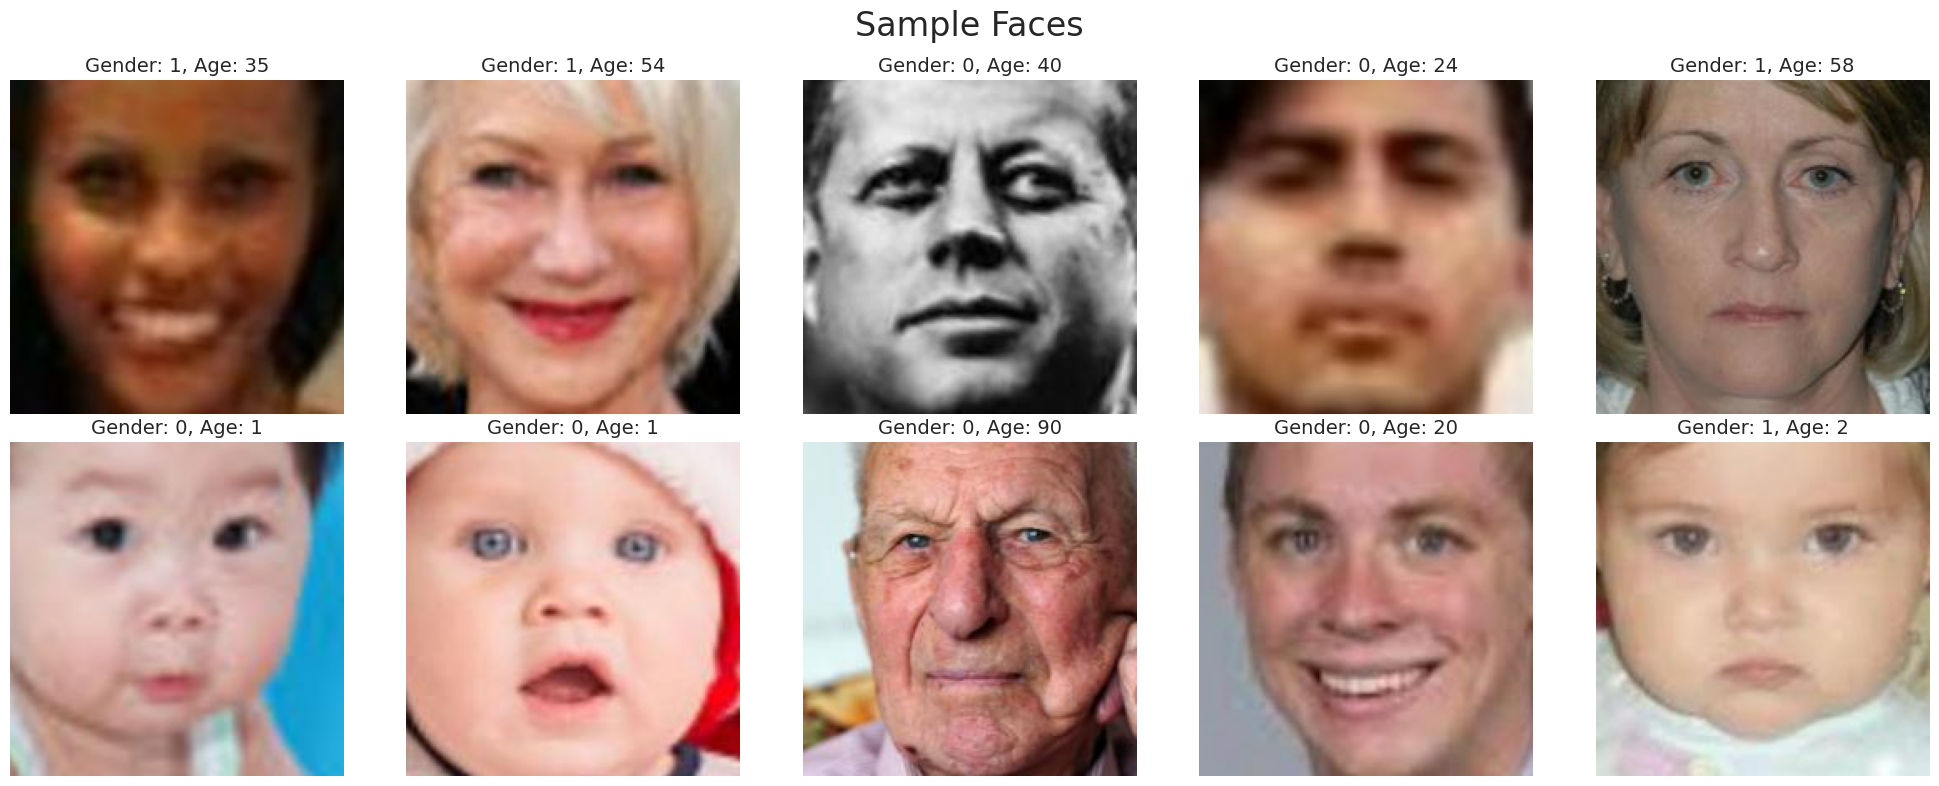

In [6]:
def plot_from_df(df: pd.DataFrame, cols: int = 4, rows: int = 3, title: str = None) -> None:
    """
    Display a grid of images with age and gender info from a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with 'img', 'age', and 'gender' columns.
        cols (int, optional): Number of columns in the grid. Default is 4.
        rows (int, optional): Number of rows in the grid. Default is 3.
        title (str, optional): Main title for the plot. Default is None.

    Returns:
        None
    """
    num_images = cols * rows
    sample_df = df.sample(n=num_images, replace=len(df) < num_images).reset_index(drop=True)

    fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(4 * cols, 4 * rows))
    ax = ax.flatten()

    for i in range(num_images):
        image_path = sample_df.loc[i, 'img']
        age = sample_df.loc[i, 'age']
        gender = sample_df.loc[i, 'gender']

        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax[i].imshow(image)
            ax[i].set_title(f'Gender: {gender}, Age: {age}', fontsize=14)
        else:
            ax[i].text(0.5, 0.5, 'Image not found', ha='center', va='center', fontsize=14)
        ax[i].axis('off')

    if title:
        fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()

plot_from_df(df, cols=5, rows=2, title="Sample Faces")

## DataLoaders & Augmentations

In [9]:
image_size = 128
num_workers = 2
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class FaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.copy()
        self.transform = transform

        self.min_age = self.df['age'].min()
        self.max_age = self.df['age'].max()
        self.age_scale = self.max_age-self.min_age
        self.df['age'] /= self.age_scale

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      img_path, age, gender = self.df.iloc[idx]
      age = torch.tensor(age, dtype=torch.float32)
      gender = torch.tensor(gender, dtype=torch.long)
      image = Image.open(img_path)
      if self.transform:
          image = self.transform(image)
      return image, age, gender

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

dataset = FaceDataset(
    df=df,
    transform=train_transforms
    )

val_split = 0.1
dataset_size = len(dataset)
train_dataset, val_dataset = random_split(dataset, [len(dataset)-int(len(dataset)*val_split), int(len(dataset)*val_split)])
val_dataset.dataset.transform = val_transforms

In [12]:
train_dataloader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_workers)

val_dataloader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

# FaceModel with Resnet BackBone

In [13]:
class FaceAgeGenderModel(nn.Module):
  def __init__(self):
    super(FaceAgeGenderModel, self).__init__()

    self.backbone = models.resnet18(pretrained=True)
    in_features = self.backbone.fc.in_features
    self.backbone.fc = nn.Identity()

    self.age_head = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Linear(128, 1)
    )

    self.gender_head = nn.Sequential(
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Linear(128, 2)
    )

  def forward(self, x):
    x = self.backbone(x)
    age = self.age_head(x)
    gender = self.gender_head(x)
    return age, gender

summary(FaceAgeGenderModel().to(device), (3,128,128))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

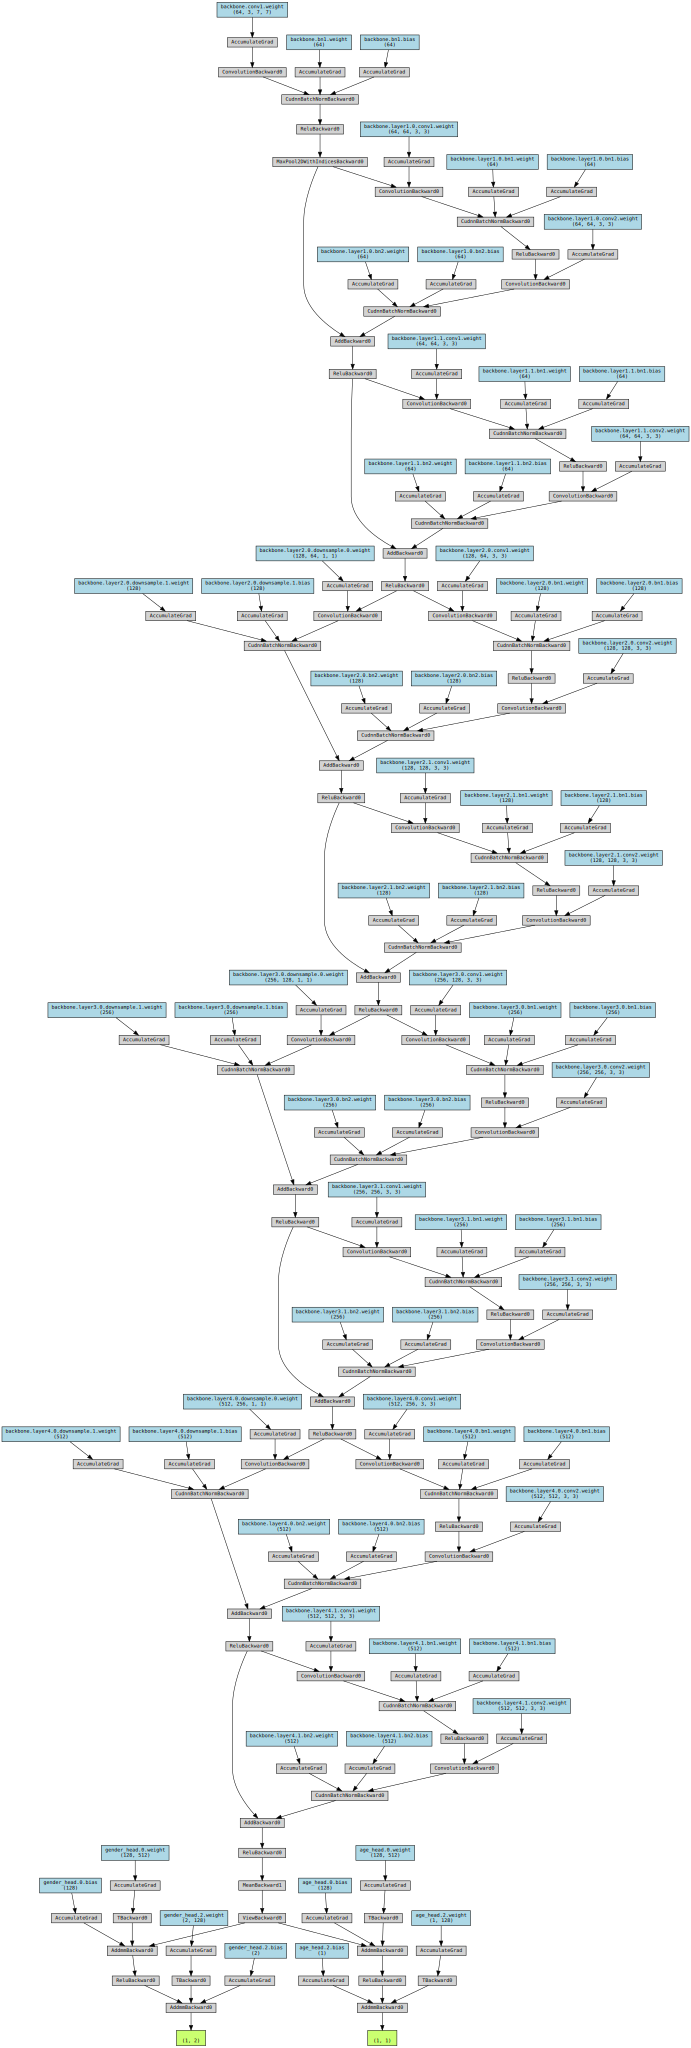

In [14]:
!pip install -q torchviz
from torchviz import make_dot
from IPython.display import display

x_in = torch.randn(1, 3, 128, 128).to(device)
model = FaceAgeGenderModel().to(device)
yhat = model(x_in)
dot = make_dot(yhat, params=dict(list(model.named_parameters())))
display(dot)

# Training    

In [18]:
model = FaceAgeGenderModel().to(device)

gender_loss = nn.CrossEntropyLoss()
age_loss = nn.MSELoss()

optimizer = optim.Adam([
    {'params': model.backbone.parameters(), 'lr': 1e-4},
    {'params': model.gender_head.parameters(), 'lr': 1e-3},
    {'params': model.age_head.parameters(), 'lr': 1e-3}
])

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

Using 2 GPUs!


In [19]:
def loss_function(age_loss, gender_loss):
    return age_loss + gender_loss*0.5

class EarlyStopping:
    def __init__(self, patience=5, delta=0, mode='min'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.counter = 0
        self.best_score = float('inf') if mode == 'min' else 0

    def early_stop(self, score)->bool:
        if self.mode == 'min':
          self.best_score = min(self.best_score, score)
          if self.best_score - score < -self.delta:
            self.counter += 1
            if self.counter >= self.patience:
              return True
        else:
          self.best_score = min(self.best_score, score)
          if self.best_score - score > self.delta:
            self.counter += 1
            if self.counter >= self.patience:
              return True
        return False

early_stopping = EarlyStopping(patience=5)

for real in train_dataloader:
    print([item.shape for item in real])
    preds = model(real[0].to(device))
    print([item.shape for item in preds])
    print(age_loss(preds[0][:, 0], real[1].to(device)))
    print(gender_loss(preds[1], real[2].to(device)))
    break

[torch.Size([128, 3, 128, 128]), torch.Size([128]), torch.Size([128])]
[torch.Size([128, 1]), torch.Size([128, 2])]
tensor(0.0607, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7108, device='cuda:0', grad_fn=<NllLossBackward0>)


In [20]:
epochs = 20
history = {
    "train_age": [],
    "train_gender": [],
    "val_age": [],
    "val_gender": []
}

for epoch in range(epochs):
    train_age_loss, train_gender_loss = 0.0, 0.0
    model.train()
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for batch in pbar:
        optimizer.zero_grad()
        images, ages, genders = batch
        images, ages, genders = images.to(device), ages.to(device), genders.to(device)
        age_pred, gender_pred = model(images)
        
        age_loss_value = age_loss(age_pred.squeeze(1), ages)
        gender_loss_value = gender_loss(gender_pred, genders)
        loss = loss_function(age_loss_value, gender_loss_value)
        loss.backward()
        optimizer.step()

        train_age_loss +=  age_loss_value.item()/len(batch[0])
        train_gender_loss += gender_loss_value.item()/len(batch[0])

    scheduler.step()
    history["train_age"].append(train_age_loss)
    history["train_gender"].append(train_gender_loss)
    
    model.eval()
    val_age_loss, val_gender_loss = 0.0, 0.0
    with torch.no_grad():
      for batch in val_dataloader:
        images, ages, genders = batch
        images, ages, genders = images.to(device), ages.to(device), genders.to(device)
        age_pred, gender_pred = model(images)
        age_loss_value = age_loss(age_pred.squeeze(1), ages)
        gender_loss_value = gender_loss(gender_pred, genders)
    
        val_age_loss += age_loss_value.item()/len(batch[0])
        val_gender_loss += gender_loss_value.item()/len(batch[0])
          
    history["val_age"].append(val_age_loss)
    history["val_gender"].append(val_gender_loss)

    print_val = f"{clrd('Loss_Age:', 'special')} {train_age_loss:.5f}   "
    print_val += f"{clrd('Loss_Gender:', 'status')} {train_gender_loss:.5f}   "
    print_val += f"{clrd('Val_Loss_Age:', 'special')} {val_age_loss:.5f}   "
    print_val += f"{clrd('Val_Loss_Gender:', 'status')} {val_gender_loss:.5f}"
    print(print_val)
    if early_stopping.early_stop(loss_function(val_age_loss, val_gender_loss)):
        print(clrd(f"Early stopping triggered at epoch {epoch+1}", 'log'))
        break

Epoch 1/20:   0%|          | 0/167 [00:00<?, ?it/s]

Loss_Age: 0.03915   Loss_Gender: 0.36370   Val_Loss_Age: 0.00120   Val_Loss_Gender: 0.03251


Epoch 2/20:   0%|          | 0/167 [00:00<?, ?it/s]

Loss_Age: 0.00939   Loss_Gender: 0.17353   Val_Loss_Age: 0.00113   Val_Loss_Gender: 0.03022


Epoch 3/20:   0%|          | 0/167 [00:00<?, ?it/s]

Loss_Age: 0.00804   Loss_Gender: 0.09656   Val_Loss_Age: 0.00117   Val_Loss_Gender: 0.03751


Epoch 4/20:   0%|          | 0/167 [00:00<?, ?it/s]

Loss_Age: 0.00713   Loss_Gender: 0.05826   Val_Loss_Age: 0.00105   Val_Loss_Gender: 0.03620


Epoch 5/20:   0%|          | 0/167 [00:00<?, ?it/s]

Loss_Age: 0.00642   Loss_Gender: 0.03952   Val_Loss_Age: 0.00102   Val_Loss_Gender: 0.03877


Epoch 6/20:   0%|          | 0/167 [00:00<?, ?it/s]

Loss_Age: 0.00611   Loss_Gender: 0.03928   Val_Loss_Age: 0.00099   Val_Loss_Gender: 0.03949


Epoch 7/20:   0%|          | 0/167 [00:00<?, ?it/s]

Loss_Age: 0.00540   Loss_Gender: 0.02065   Val_Loss_Age: 0.00097   Val_Loss_Gender: 0.04787
Early stopping triggered at epoch 7


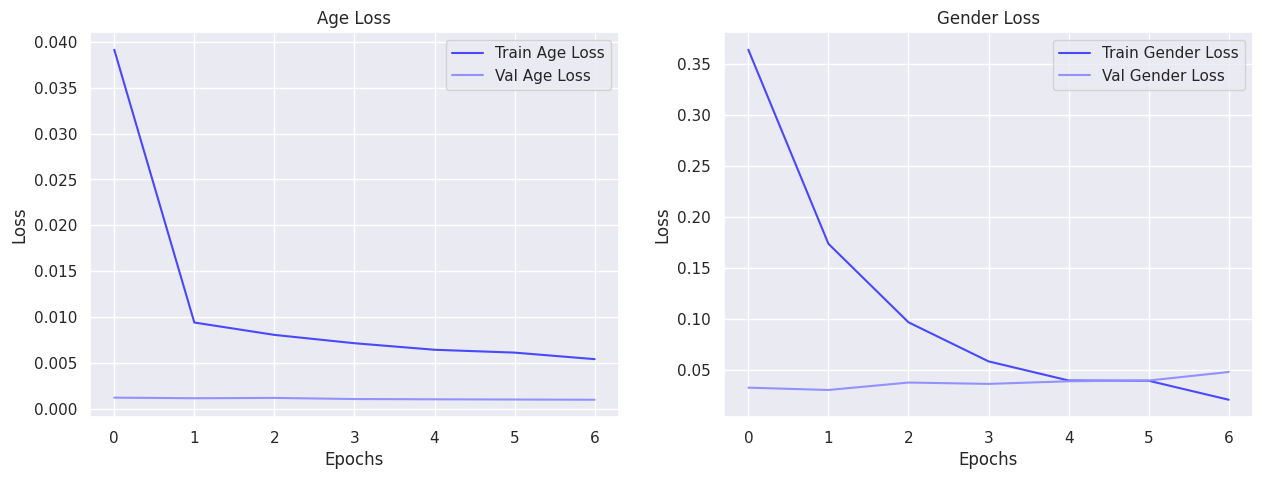

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history["train_age"], label="Train Age Loss")
ax[0].plot(history["val_age"], label="Val Age Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Age Loss")
ax[0].legend()

ax[1].plot(history["train_gender"], label="Train Gender Loss")
ax[1].plot(history["val_gender"], label="Val Gender Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("Gender Loss")
ax[1].legend()

plt.show()

# Inference

[{'age': 0.8876975178718567, 'gender': 0}]

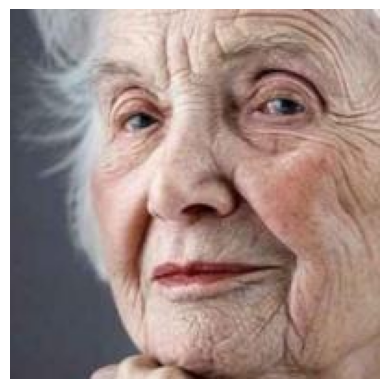

In [28]:
def inference_on_images(model,
                        val_transforms,
                        imgs: list[str] | list[Image.Image],
                        device='cpu'
                       )->list[dict]:
    if type(imgs[0]) == str:
        imgs = [Image.open(img) for img in imgs]
    model.eval()
    with torch.no_grad():
        images = torch.stack([val_transforms(img) for img in imgs]).to(device)
        age_pred, gender_pred = model(images)
    res = []
    for i, _ in enumerate(imgs):
        res.append({
            "age": float(age_pred[i, 0]),
            "gender": int(gender_pred[i, 0]>0.5)
        })
    return res

#=============> INFERENCE <==============
img_path = r"/kaggle/input/utkface-new/UTKFace/100_1_0_20170112213303693.jpg.chip.jpg"
plt.imshow(Image.open(img_path))
plt.axis('off')
inference_on_images(model, val_transforms, [img_path], device)